###### <span style="color: gray ">Import All Required Libraries / นำเข้าคลาสและไลบรารีที่จำเป็นทั้งหมด</span>


In [1]:
# Libraries for numerical computation and data analysis /
# ไลบรารีสำหรับการคำนวณเชิงตัวเลขและการวิเคราะห์ข้อมูล
import numpy as np
import pandas as pd

# Libraries for plotting graphs /
# ไลบรารีสำหรับการวาดกราฟ
import matplotlib.pyplot as plt

# Libraries for statistical and signal processing functions /
# ไลบรารีสำหรับสถิติและการประมวลผลสัญญาณ
from scipy import signal
from scipy.signal import savgol_filter

# Libraries for hyperspectral image processing /
# ไลบรารีสำหรับการประมวลผลภาพไฮเปอร์สเปกตรัม
from spectral import imshow
import spectral.io.envi as envi

# Libraries for image analysis /
# ไลบรารีสำหรับการวิเคราะห์ภาพ
import cv2

# Module for random number generation /
# โมดูลสำหรับการสร้างตัวเลขสุ่ม
import random

# Machine learning models and evaluation metrics /
# โมเดลการเรียนรู้ของเครื่องและเมตริกสำหรับประเมินผล
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

# Library for image processing /
# ไลบรารีสำหรับการประมวลผลภาพ
from skimage.filters import threshold_otsu

# Deep learning framework /
# เฟรมเวิร์กสำหรับการเรียนรู้เชิงลึก
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Dataset /
# ชุดข้อมูล
from keras.datasets import cifar10


C:\Users\tetsu\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


# <span style="color:RoyalBlue; ">12.2 Structure and Loading of NIR–HSI Data / โครงสร้างและการโหลดข้อมูล NIR–HSI</span>

###### <span style="color: gray ">Code 12.1 Loading HSI Data and Displaying Its Overview / โค้ด 12.1 การโหลดข้อมูล HSI และแสดงภาพรวม</span>


In [2]:
dark_ref=envi.open("dataChapter12/dark.hdr","dataChapter12/dark.raw")
white_ref=envi.open("dataChapter12/white.hdr","dataChapter12/white.raw")
wood_ref=envi.open("dataChapter12/wood.hdr","dataChapter12/wood.raw")
print(white_ref)
print(wood_ref)

	Data Source:   '.\dataChapter12/white.raw'
	# Rows:              1
	# Samples:         320
	# Bands:           256
	Interleave:        BIL
	Quantization:  16 bits
	Data format:    uint16
	Data Source:   '.\dataChapter12/wood.raw'
	# Rows:            280
	# Samples:         320
	# Bands:           256
	Interleave:        BIL
	Quantization:  16 bits
	Data format:    uint16


C:\Users\tetsu\anaconda3\Lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


###### <span style="color: gray ">Code 12.2 Calculation of Reflectance / โค้ด 12.2 การคำนวณรีเฟล็กแทนซ์ (Reflectance)</span>


In [3]:
# Convert to arrays / แปลงเป็นอาเรย์
white = np.array(white_ref.load())
dark = np.array(dark_ref.load())
wood = np.array(wood_ref.load())

# Extract wavelength data / ดึงข้อมูลความยาวคลื่น
wave = wood_ref.metadata['wavelength']
wave = np.array(wave, dtype=float)

# Calculate reflectance / คำนวณค่าการสะท้อนแสง (Reflectance)
ref_sample = np.divide(np.subtract(wood, dark), np.subtract(white, dark))

print("white", white.shape)
print("dark", dark.shape)
print("wood", wood.shape)
print("Reflectance / ค่าการสะท้อนแสง", ref_sample.shape)


white (1, 320, 256)
dark (1, 320, 256)
wood (280, 320, 256)
Reflectance / ค่าการสะท้อนแสง (280, 320, 256)


C:\Users\tetsu\AppData\Local\Temp\ipykernel_30404\1563512857.py:11: RuntimeWarning: invalid value encountered in divide
  ref_sample = np.divide(np.subtract(wood, dark), np.subtract(white, dark))


# <span style="color:RoyalBlue; ">12.3 Image and Spectrum Extraction / การแยกภาพและสเปกตรัม</span>

###### <span style="color: gray ">Code 12.3 Display Image at Arbitrary Wavelength / โค้ด 12.3 แสดงภาพที่ความยาวคลื่นที่กำหนด</span>


In [4]:
def get_image_at_wavelength(sample, waveinf, wavelength):
    """
    Parameters:
    ref_sample (numpy.ndarray): HSI data (shape: [height, width, number of wavelengths]) /
                                ข้อมูล HSI (รูปร่าง: [ความสูง, ความกว้าง, จำนวนความยาวคลื่น])
    wave (numpy.ndarray): Wavelength data (shape: [number of wavelengths,]) /
                          ข้อมูลความยาวคลื่น (รูปร่าง: [จำนวนความยาวคลื่น])
    wavelength (float): Specific wavelength to extract /
                        ความยาวคลื่นที่ต้องการดึงออกมา

    Returns:
    numpy.ndarray: Image at the specified wavelength (shape: [height, width]) /
                   ภาพที่ความยาวคลื่นที่กำหนด (รูปร่าง: [ความสูง, ความกว้าง])
    """
    # Find index closest to specified wavelength /
    # หาดัชนีที่ใกล้เคียงกับความยาวคลื่นที่กำหนดมากที่สุด
    idx = np.argmin(np.abs(waveinf - wavelength))
    
    # Get image at that wavelength /
    # ดึงภาพที่ความยาวคลื่นนั้น
    image = ref_sample[:, :, idx]
    
    plt.figure(figsize=(6, 6))
    img = plt.imshow(image, cmap='viridis')
    plt.colorbar(img, orientation='horizontal', shrink=0.8, aspect=40, pad=0.05)
    plt.title(f'Image at {wavelength} nm')
    plt.show()


###### <span style="color: gray ">Code 12.4 Execution of get_image_at_wavelength Function / โค้ด 12.4 การเรียกใช้ฟังก์ชัน get_image_at_wavelength</span>


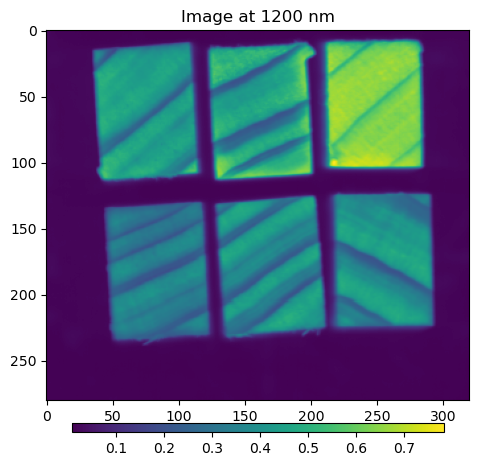

In [5]:
get_image_at_wavelength(ref_sample, wave, 1200)

###### <span style="color: gray ">Code 12.5 Display Spectra at Two Arbitrary Pixels and Image of Their Spectral Dot Product / โค้ด 12.5 แสดงสเปกตรัมที่ตำแหน่งพิกเซลสองจุดและภาพผลคูณดอทของสเปกตรัม</span>


In [6]:
def plot_spectrum_and_sum_image(sample, waveinf, x1, y1, x2, y2):
    """
    Parameters:
    sample (numpy.ndarray): HSI data (shape: [height, width, number of wavelengths]) /
                            ข้อมูล HSI (รูปร่าง: [ความสูง, ความกว้าง, จำนวนความยาวคลื่น])
    waveinf (numpy.ndarray): Wavelength data (shape: [number of wavelengths]) /
                             ข้อมูลความยาวคลื่น (รูปร่าง: [จำนวนความยาวคลื่น])
    x1, y1 (int): Coordinates of the first selected pixel /
                  ตำแหน่งพิกเซลจุดที่ 1
    x2, y2 (int): Coordinates of the second selected pixel /
                  ตำแหน่งพิกเซลจุดที่ 2

    Returns:
    None
    """

    # Get spectra at specific locations / ดึงสเปกตรัมที่ตำแหน่งเฉพาะ
    spectrum1 = sample[y1, x1, :]
    spectrum2 = sample[y2, x2, :]

    # Compute sum over wavelengths / คำนวณผลรวมในแต่ละพิกเซลตลอดทุกความยาวคลื่น
    sum_image = np.sum(sample, axis=2)

    plt.figure(figsize=(8, 8))

    # Display summed image / แสดงภาพผลรวมของสเปกตรัม
    plt.subplot(2, 1, 1)
    plt.imshow(sum_image, cmap='gray')
    plt.colorbar(label='Sum')
    plt.scatter(x1, y1, color='magenta', marker='x')  # Mark first location / ทำเครื่องหมายตำแหน่งที่ 1 ด้วยสีชมพู
    plt.scatter(x2, y2, color='cyan', marker='x')     # Mark second location / ทำเครื่องหมายตำแหน่งที่ 2 ด้วยสีฟ้า
    plt.title('Sum Image')

    # Plot spectra from the two locations / แสดงกราฟของสเปกตรัมทั้งสองจุด
    plt.subplot(2, 1, 2)
    plt.plot(waveinf, spectrum1, color='magenta', label=f'Spectrum at ({x1}, {y1})')
    plt.plot(waveinf, spectrum2, color='cyan', label=f'Spectrum at ({x2}, {y2})')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Reflectance')
    plt.title('Spectra at Specified Locations')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage /
# ตัวอย่างการใช้งาน:
# plot_spectrum_and_sum_image(sample, waveinf, x1, y1, x2, y2)


###### <span style="color: gray ">Code 12.6 Execution of plot_spectrum_and_sum_image Function / โค้ด 12.6 การเรียกใช้ฟังก์ชัน plot_spectrum_and_sum_image</span>


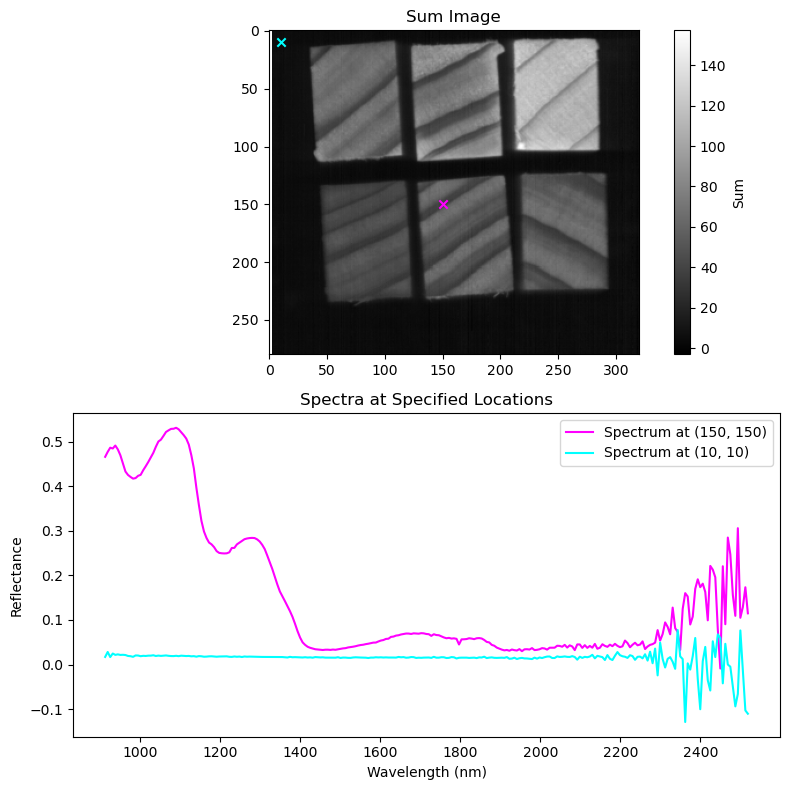

In [7]:
plot_spectrum_and_sum_image(ref_sample, wave, 150,150,10,10)

###### <span style="color: gray ">Code 12.7 Display of Reference Light Data, Dark Data, and Sample Reflected Light / โค้ด 12.7 การแสดงข้อมูลแสงอ้างอิง ข้อมูลมืด และแสงสะท้อนจากตัวอย่าง</span>


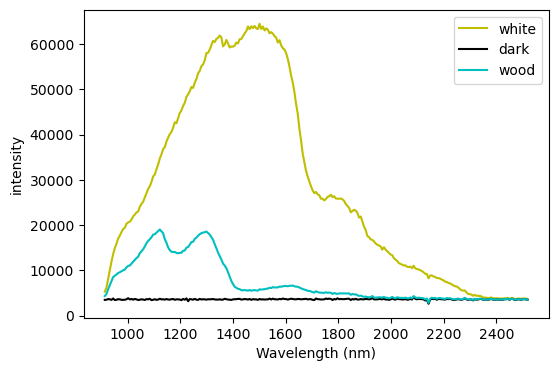

In [8]:
plt.figure(figsize=(6, 4))
plt.plot(wave,white[0,150,:],'y-',label= "white")
plt.plot(wave,dark[0,150,:],'k-',label= "dark")
plt.plot(wave,wood[150,150,:],'c-',label= "wood")
plt.xlabel('Wavelength (nm)')
plt.ylabel('intensity')
plt.legend()

# <span style="color:RoyalBlue; ">12.4 Extraction of Spectra and Images from Wood Sample Regions / การแยกสเปกตรัมและภาพจากบริเวณตัวอย่างไม้</span>

## <span style="color: DeepPink; ">12.4.1 Extraction of HSI and Spectra in Arbitrary Wavelength Regions / การแยก HSI และสเปกตรัมในช่วงความยาวคลื่นที่กำหนด</span>

###### <span style="color: gray ">Code 12.8 Extraction of Image and Spectra in Arbitrary Wavelength Regions / โค้ด 12.8 การแยกภาพและสเปกตรัมในช่วงความยาวคลื่นที่กำหนด</span>


In [9]:
def extract_image(sample, waveinf, minz, maxz):
    """
    Extract image data and wavelength information within a specific wavelength range /
    ดึงข้อมูลภาพและความยาวคลื่นภายในช่วงความยาวคลื่นที่กำหนด

    Parameters:
    sample (numpy.ndarray): HSI data (shape: [height, width, number of wavelengths]) /
                            ข้อมูล HSI (รูปร่าง: [ความสูง, ความกว้าง, จำนวนความยาวคลื่น])
    waveinf (numpy.ndarray): Wavelength data (shape: [number of wavelengths]) /
                             ข้อมูลความยาวคลื่น (รูปร่าง: [จำนวนความยาวคลื่น])
    minz (float): Minimum wavelength for extraction /
                  ค่าความยาวคลื่นต่ำสุดที่ต้องการดึงออกมา
    maxz (float): Maximum wavelength for extraction /
                  ค่าความยาวคลื่นสูงสุดที่ต้องการดึงออกมา

    Returns:
    tuple: Extracted image data and wavelength information (numpy.ndarray, numpy.ndarray) /
           ข้อมูลภาพและความยาวคลื่นที่ถูกดึงออกมา (numpy.ndarray, numpy.ndarray)
    """

    # Find index for specified wavelength range /
    # หาดัชนีของช่วงความยาวคลื่นที่กำหนด
    idx1 = np.argmin(np.abs(waveinf - minz))
    idx2 = np.argmin(np.abs(waveinf - maxz)) + 1  # Include idx2 / รวม idx2 ด้วย

    # Extract image data within the range / ดึงข้อมูลภาพในช่วงที่กำหนด
    sample_extract = sample[:, :, idx1:idx2]
    # Extract corresponding wavelengths / ดึงข้อมูลความยาวคลื่นที่เกี่ยวข้อง
    wave_extract = waveinf[idx1:idx2]

    return sample_extract, wave_extract


###### <span style="color: gray ">Code 12.9 Execution of extract_image Function / โค้ด 12.9 การเรียกใช้ฟังก์ชัน extract_image</span>

In [10]:
sample_extract, wave_extract=extract_image(ref_sample, wave, 950, 2200)

###### <span style="color: gray ">Code 12.10 Execution of plot_spectrum_and_sum_image Function (After Extraction) / โค้ด 12.10 การเรียกใช้ฟังก์ชัน plot_spectrum_and_sum_image (หลังการดึงข้อมูล)</span>


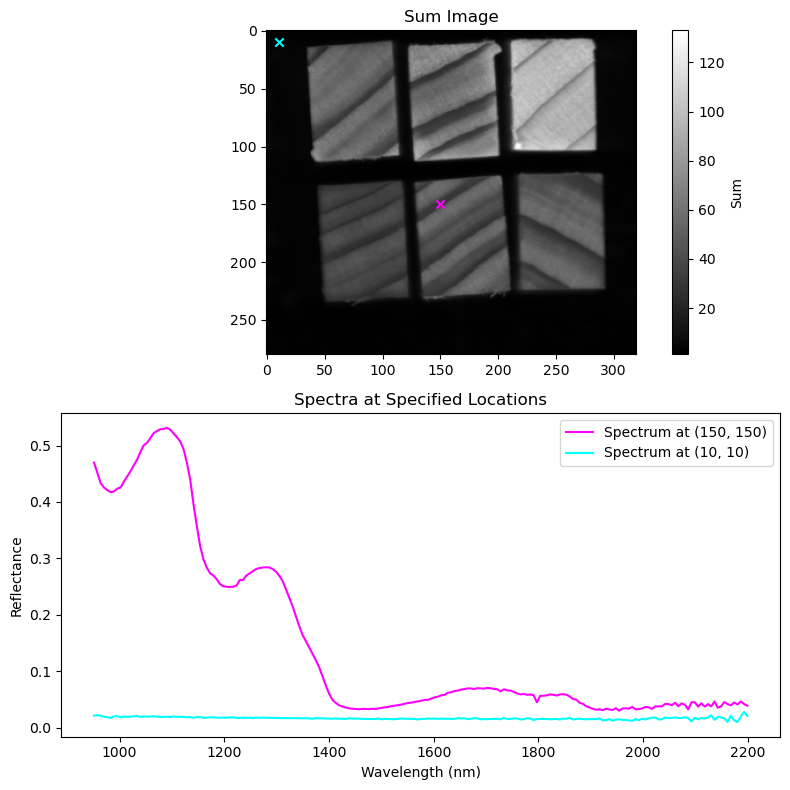

In [11]:
plot_spectrum_and_sum_image(sample_extract, wave_extract, 150,150,10,10)

## <span style="color: DeepPink; ">12.4.2 Extraction of Sample Region / การแยกบริเวณตัวอย่าง</span>

###### <span style="color: gray ">Code 12.11 Region Discrimination Using a Single Wavelength and PCA Scores / โค้ด 12.11 การจำแนกบริเวณโดยใช้ความยาวคลื่นเดียวและคะแนน PCA</span>


In [12]:
def extract_sample_region(sample, waveinf, wavelength):
    """
    Parameters:
    sample (numpy.ndarray): HSI data (shape: [height, width, number of wavelengths]) /
                            ข้อมูล HSI (รูปร่าง: [ความสูง, ความกว้าง, จำนวนความยาวคลื่น])
    waveinf (numpy.ndarray): Wavelength information (shape: [number of wavelengths]) /
                             ข้อมูลความยาวคลื่น (รูปร่าง: [จำนวนความยาวคลื่น])
    wavelength (float): Specific wavelength to extract /
                        ความยาวคลื่นเฉพาะที่ต้องการดึงออก

    Returns:
    None
    """

    # ① Extract image at specified wavelength /
    # ① ดึงภาพที่ความยาวคลื่นที่กำหนด
    # ①-1 Find index closest to specified wavelength /
    # ①-1 หาดัชนีที่ใกล้เคียงที่สุดกับความยาวคลื่นที่ระบุ
    idx = np.argmin(np.abs(waveinf - wavelength))

    # ①-2 Extract image at that wavelength /
    # ①-2 ดึงภาพจากความยาวคลื่นนั้น
    image = sample[:, :, idx]

    # ② Create PCA score images /
    # ② สร้างภาพคะแนน PCA
    # ②-1 Reshape 3D sample to 2D (pixels × wavelengths) /
    # ②-1 แปลงข้อมูล 3 มิติเป็น 2 มิติ (พิกเซล × ความยาวคลื่น)
    reshaped_sample = sample.reshape((-1, sample.shape[2]))

    # ②-2 Perform PCA and compute PC1–PC3 scores /
    # ②-2 ดำเนินการ PCA และคำนวณคะแนน PC1 ถึง PC3
    pca = PCA(n_components=3)
    pca_scores = pca.fit_transform(reshaped_sample)

    # ②-3 Reshape scores back to image dimensions (height × width × 3) /
    # ②-3 แปลงกลับเป็นภาพ 3 มิติ (ความสูง × ความกว้าง × 3)
    pc_images = pca_scores.reshape((sample.shape[0], sample.shape[1], 3))

    # ③ Binarize using Otsu's method (wood=1, background=0) /
    # ③ ทำการแปลงเป็นภาพไบนารีโดยใช้วิธีของ Otsu (ไม้=1, พื้นหลัง=0)
    binary_image = (image > threshold_otsu(image)).astype(int)
    pc1_binary = (pc_images[:, :, 0] > threshold_otsu(pc_images[:, :, 0])).astype(int)
    pc2_binary = (pc_images[:, :, 1] > threshold_otsu(pc_images[:, :, 1])).astype(int)
    pc3_binary = (pc_images[:, :, 2] > threshold_otsu(pc_images[:, :, 2])).astype(int)

    # Display images / แสดงภาพ
    plt.figure(figsize=(12, 9))

    plt.subplot(3, 4, 1)
    plt.imshow(image, cmap='gray')
    plt.title(f'Image at {wavelength} nm')

    plt.subplot(3, 4, 5)
    plt.imshow(binary_image, cmap='gray')
    plt.title('Binary image')

    plt.subplot(3, 4, 2)
    plt.imshow(pc_images[:, :, 0], cmap='gray')
    plt.title('PC1 score image')

    plt.subplot(3, 4, 6)
    plt.imshow(pc1_binary, cmap='gray')
    plt.title('PC1 binary image')

    plt.subplot(3, 4, 10)
    plt.plot(pca.components_[0])
    plt.title('PC1 loading')

    plt.subplot(3, 4, 3)
    plt.imshow(pc_images[:, :, 1], cmap='gray')
    plt.title('PC2 score image')

    plt.subplot(3, 4, 7)
    plt.imshow(pc2_binary, cmap='gray')
    plt.title('PC2 binary image')

    plt.subplot(3, 4, 11)
    plt.plot(pca.components_[1])
    plt.title('PC2 loading')

    plt.subplot(3, 4, 4)
    plt.imshow(pc_images[:, :, 2], cmap='gray')
    plt.title('PC3 score image')

    plt.subplot(3, 4, 8)
    plt.imshow(pc3_binary, cmap='gray')
    plt.title('PC3 binary image')

    plt.subplot(3, 4, 12)
    plt.plot(pca.components_[2])
    plt.title('PC3 loading')

    plt.tight_layout()
    plt.show()

    return binary_image, pc1_binary, pc2_binary, pc3_binary


###### <span style="color: gray ">Code 12.12 Execution of extract_sample_region Function / โค้ด 12.12 การเรียกใช้ฟังก์ชัน extract_sample_region</span>


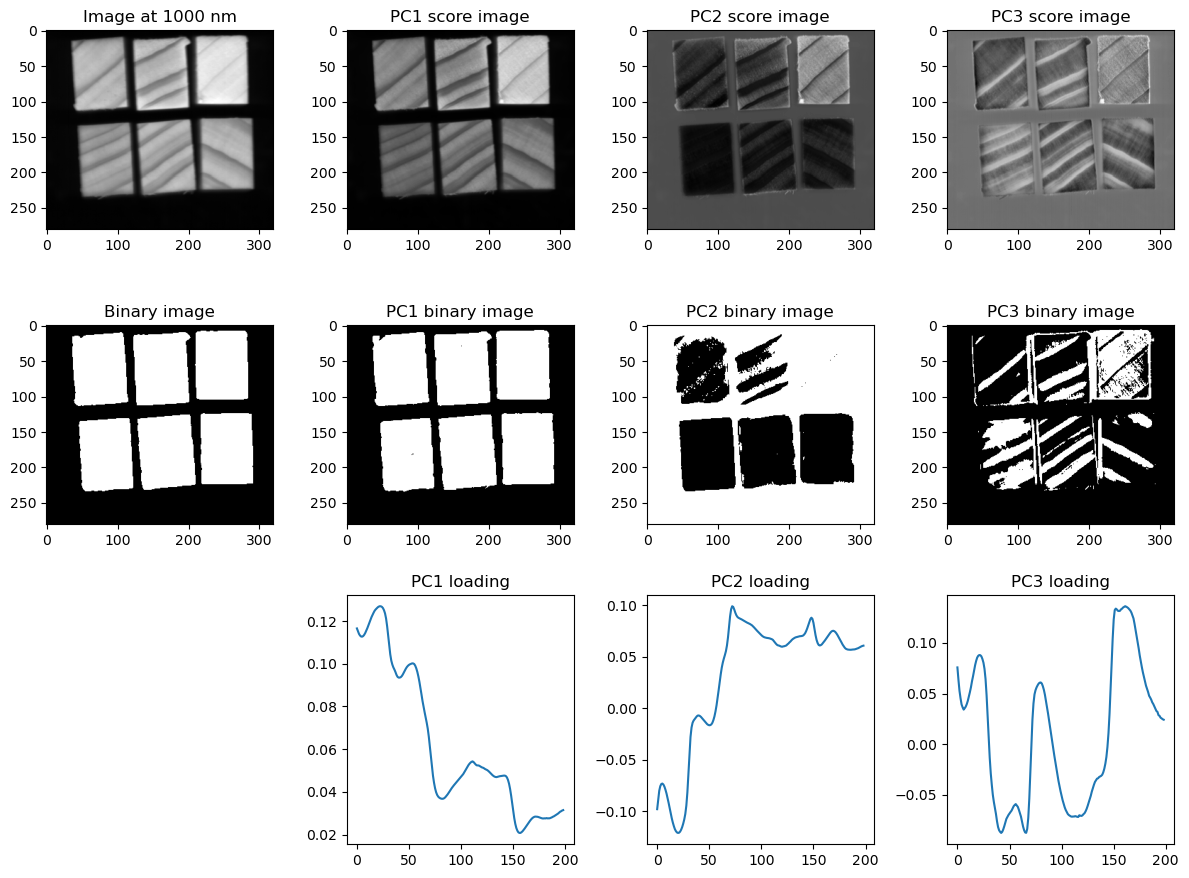

In [13]:
binary_image,pc1_binary,pc2_binary,pc3_binary=extract_sample_region(sample_extract, wave_extract,1000)

###### <span style="color: gray ">Code 12.13 Execution of connectedComponentsWithStats Function / โค้ด 12.13 การเรียกใช้ฟังก์ชัน connectedComponentsWithStats</span>


In [15]:
# retval, labels, stats, centroids = cv2.connectedComponentsWithStats(image)

###### <span style="color: gray ">Code 12.14 Assigning Label Numbers to Specific Regions Based on Binarized Image / โค้ด 12.14 การกำหนดหมายเลขป้ายกำกับให้กับบริเวณเฉพาะจากภาพไบนารี</span>


In [16]:
def analyze_binary_image(sample, waveinf, binary_im):
    """
    Parameters:
    sample (numpy.ndarray): HSI data (shape: [height, width, number of wavelengths]) /
                            ข้อมูล HSI (รูปร่าง: [ความสูง, ความกว้าง, จำนวนความยาวคลื่น])
    waveinf (numpy.ndarray): Wavelength data (shape: [number of wavelengths]) /
                             ข้อมูลความยาวคลื่น (รูปร่าง: [จำนวนความยาวคลื่น])
    binary_image (numpy.ndarray): Binary image (shape: [height, width]) /
                                  ภาพไบนารี (รูปร่าง: [ความสูง, ความกว้าง])

    Returns:
    None
    """

    # ① Create sum image across wavelengths /
    # ① สร้างภาพผลรวมตลอดทุกความยาวคลื่น
    sum_image = np.sum(sample, axis=2)
    binary_im = (binary_im * 255).astype(np.uint8)

    # ② Analyze connected components with stats /
    # ② วิเคราะห์องค์ประกอบที่เชื่อมต่อโดยใช้ connectedComponentsWithStats
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_im)

    # ③ Display the labeled regions /
    # ③ แสดงบริเวณที่มีป้ายกำกับ
    plt.figure(figsize=(6, 6))
    marked_image = sum_image.copy()

    for i in range(1, num_labels):  # Skip background / ข้ามฉากหลัง (label 0)
        print(f'Component {i} stats: {stats[i]}')
        marked_image[labels == i] = 100
        x, y = int(centroids[i][0]), int(centroids[i][1])
        cv2.putText(marked_image, str(i), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

    plt.imshow(marked_image, cmap='magma')
    plt.title('connectedComponentsWithStats')
    plt.tight_layout()
    plt.show()

    return num_labels, labels, stats, centroids


###### <span style="color: gray ">Code 12.15 Execution of analyze_binary_image Function / โค้ด 12.15 การเรียกใช้ฟังก์ชัน analyze_binary_image</span>


Component 1 stats: [ 210    8   75   97 7074]
Component 2 stats: [  37   10   79  104 7270]
Component 3 stats: [ 123   10   81  103 7440]
Component 4 stats: [ 218  124   74  100 7239]
Component 5 stats: [ 129  126   82  106 7584]
Component 6 stats: [  46  131   77  103 7187]


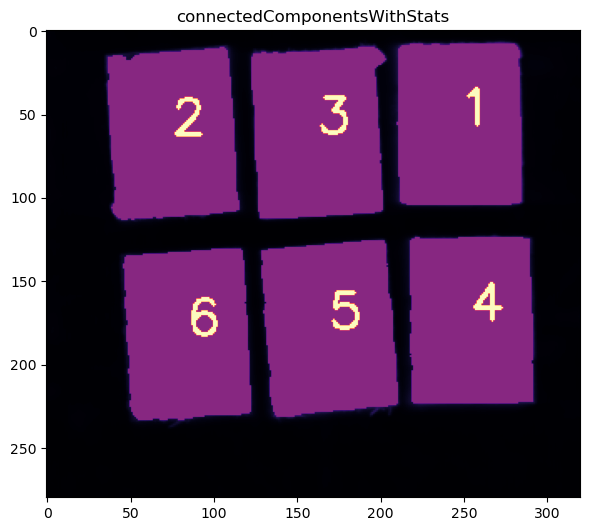

In [17]:
num_labels, labels, stats, centroids=analyze_binary_image(sample_extract, wave_extract, binary_image)

# <span style="color:RoyalBlue; ">12.5 Visualization of Spatial Distribution of Predicted Values Using PLS Regression / การแสดงการกระจายเชิงพื้นที่ของค่าที่คาดการณ์โดยใช้การถดถอยแบบ PLS</span>

###### <span style="color: gray ">Code 12.16 Loading Moisture Content Data / โค้ด 12.16 การโหลดข้อมูลปริมาณความชื้น</span>


In [18]:
# Load moisture content data / โหลดข้อมูลปริมาณความชื้น
mc = pd.read_csv('dataChapter12/HSI_mc.csv') 
mc = mc.rename(columns={'Unnamed: 0': ''})
mc = mc.set_index('')
print(mc)


           mc
             
1    9.808280
2   65.889571
3   96.082474
4  104.445664
5   92.848572
6  120.367111


###### <span style="color: gray ">Code 12.17 Calculation of Mean Spectrum for Each Wood Sample / โค้ด 12.17 การคำนวณสเปกตรัมเฉลี่ยของตัวอย่างไม้แต่ละชิ้น</span>


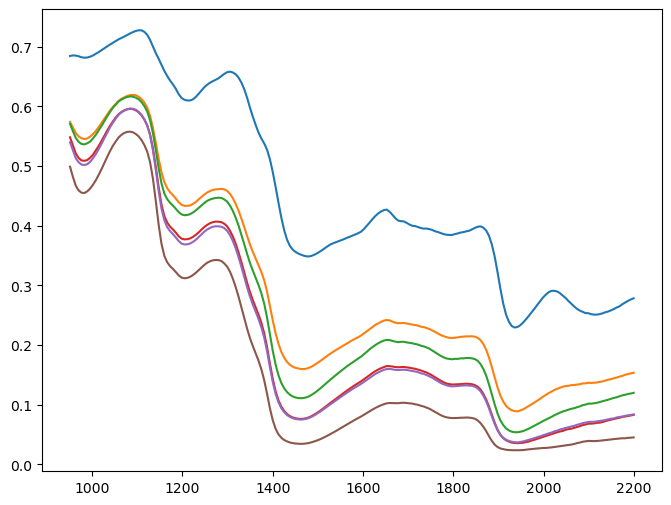

In [19]:
average_spectra = []  # Create an empty list to store average spectra / สร้างลิสต์เปล่าสำหรับเก็บสเปกตรัมเฉลี่ย
sample_order = [1, 3, 2, 4, 5, 6]  # ① Specify sample order / กำหนดลำดับของตัวอย่าง

# Process each labeled region / ประมวลผลสำหรับแต่ละป้ายกำกับ
for label in sample_order:
    indices = np.where(labels == label)  # ② Get pixel indices for this label / ดึงดัชนีพิกเซลที่ตรงกับป้ายกำกับ
    component_spectra = sample_extract[indices[0], indices[1], :]  # ③ Extract corresponding spectra / ดึงสเปกตรัมที่สอดคล้องกัน
    avg_spectrum = np.mean(component_spectra, axis=0)  # ④ Calculate average spectrum / คำนวณสเปกตรัมเฉลี่ย
    average_spectra.append(avg_spectrum)  # Append to list / เพิ่มไปยังลิสต์

average_spectra = np.array(average_spectra)  # Convert list to NumPy array / แปลงลิสต์เป็นอาเรย์ NumPy

# Plot average spectra / แสดงกราฟสเปกตรัมเฉลี่ย
plt.figure(figsize=(8, 6))
plt.plot(wave_extract, average_spectra.T)


###### <span style="color: gray ">Code 12.18 Spectral Analysis and Visualization of Spatial Distribution of Predicted Values Using PLS Regression / โค้ด 12.18 การวิเคราะห์สเปกตรัมและการแสดงการกระจายเชิงพื้นที่ของค่าที่คาดการณ์โดยใช้การถดถอย PLS</span>


In [20]:
def analyze_spectra(sample, waveinf, labelsin, sample_order, prop, n_components, filter_size=0, vmin=None, vmax=None):
    """
    Parameters:
    sample (numpy.ndarray): Reflectance data (shape: [y, x, number of wavelengths]) /
                            ข้อมูลรีเฟล็กแทนซ์ (รูปร่าง: [y, x, จำนวนความยาวคลื่น])
    waveinf (numpy.ndarray): Wavelength information (shape: [number of wavelengths]) /
                             ข้อมูลความยาวคลื่น (รูปร่าง: [จำนวนความยาวคลื่น])
    labelsin (numpy.ndarray): Sample region labels (shape: [y, x]) /
                              ป้ายกำกับบริเวณตัวอย่าง (รูปร่าง: [y, x])
    sample_order (list): Order of sample regions / ลำดับของบริเวณตัวอย่าง
    prop (numpy.ndarray): Target values for PLS regression / ค่าตัวแปรเป้าหมายสำหรับการถดถอย PLS
    n_components (int): Number of PLS components / จำนวนองค์ประกอบ PLS
    filter_size (int): Size of Gaussian filter (default: 0, no filtering) /
                       ขนาดของ Gaussian filter (ค่าเริ่มต้น: 0, ไม่ฟิลเตอร์)
    vmin (float): Minimum value for predicted map visualization (optional) /
                  ค่าต่ำสุดในการแสดงแผนที่ค่าที่คาดการณ์ (ไม่จำเป็น)
    vmax (float): Maximum value for predicted map visualization (optional) /
                  ค่าสูงสุดในการแสดงแผนที่ค่าที่คาดการณ์ (ไม่จำเป็น)

    Returns:
    numpy.ndarray: Average spectra of each region /
                   สเปกตรัมเฉลี่ยของแต่ละบริเวณ
    """

    # Calculate average spectra for each label / คำนวณสเปกตรัมเฉลี่ยสำหรับแต่ละป้ายกำกับ
    average_spectra = []
    for label in sample_order:
        indices = np.where(labelsin == label)
        component_spectra = sample[indices[0], indices[1], :]
        avg_spectrum = np.mean(component_spectra, axis=0)
        average_spectra.append(avg_spectrum)
    average_spectra = np.array(average_spectra)

    # Plot average spectra / แสดงกราฟสเปกตรัมเฉลี่ย
    plt.figure(figsize=(8, 6))
    plt.plot(waveinf, average_spectra.T)
    plt.xlabel('Wavelength')
    plt.ylabel('Reflectance')
    plt.title('Average Spectra')
    plt.show()

    # Fit PLS regression with specified components / ทำการถดถอย PLS ด้วยจำนวนองค์ประกอบที่กำหนด
    plsr = PLSRegression(n_components=n_components)
    plsr.fit(average_spectra, prop)
    prop_pred = plsr.predict(average_spectra)
    r2 = r2_score(prop, prop_pred)
    mse = mean_squared_error(prop, prop_pred)
    print(f"R2: {r2}")
    print(f"MSE: {mse}")

    # Plot measured vs predicted / แสดงกราฟค่าที่วัดได้เทียบกับค่าที่คาดการณ์
    plt.figure(figsize=(8, 6))
    plt.scatter(prop, prop_pred, alpha=0.7, color='blue')
    plt.xlabel('Measured')
    plt.ylabel('Predicted')
    plt.title(f'Measured vs. Predicted (R2: {r2:.2f}, MSE: {mse:.2f})')
    plt.show()

    # Plot regression coefficients / แสดงกราฟค่าสัมประสิทธิ์การถดถอย
    plt.figure(figsize=(8, 6))
    plt.plot(waveinf, plsr.coef_.flatten())
    plt.xlabel('Wavelength')
    plt.ylabel('Regression Coefficient')
    plt.title('Regression Coefficient Spectrum')
    plt.show()

    # ① Apply PLS model to each pixel in spectra /
    # ① ใช้โมเดล PLS กับแต่ละพิกเซลในสเปกตรัม
    # ①-1 Create empty matrix / สร้างเมทริกซ์เปล่า
    predicted_spectra = np.zeros_like(sample[:, :, 0])
    for label in sample_order:
        indices = np.where(labelsin == label)  # ①-2 Get pixel indices by label / ดึงดัชนีพิกเซลตามป้ายกำกับ
        predicted_spectra[indices] = plsr.predict(sample[indices[0], indices[1], :]).flatten()  # ①-3 Predict per pixel / คาดการณ์ทีละพิกเซล

    # ② Apply Gaussian filter to prediction (if filter_size > 0) /
    # ② ใช้ Gaussian filter กับผลการคาดการณ์ (หาก filter_size > 0)
    if filter_size > 0:
        predicted_spectra = cv2.GaussianBlur(predicted_spectra, (filter_size, filter_size), 0)

    # Show predicted map / แสดงแผนที่ค่าที่คาดการณ์
    plt.figure(figsize=(8, 6))
    plt.imshow(predicted_spectra, cmap='jet', vmin=vmin, vmax=vmax)
    plt.colorbar(label='Predicted Property')
    plt.title('Predicted Property Map')
    plt.show()


###### <span style="color: gray ">Code 12.19 Execution of analyze_spectra Function / โค้ด 12.19 การเรียกใช้ฟังก์ชัน analyze_spectra</span>


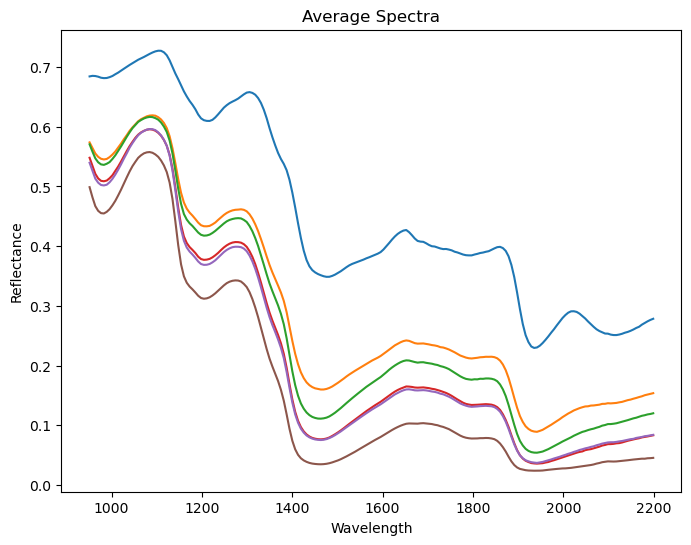

R2: 0.9788960207929477
MSE: 27.301339112674487


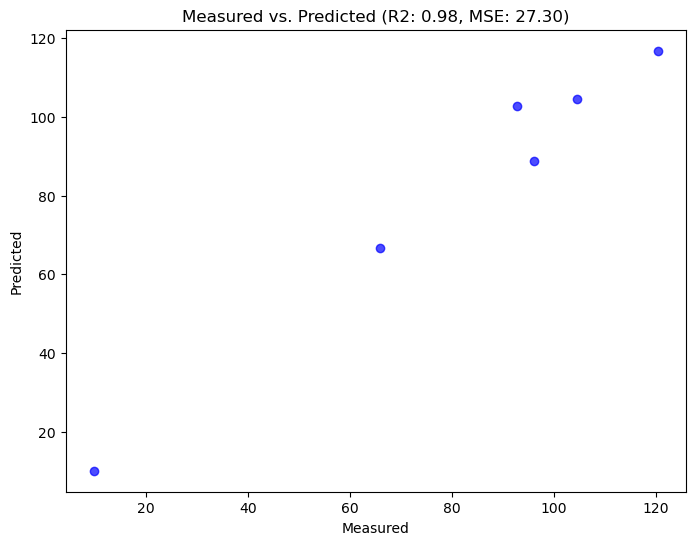

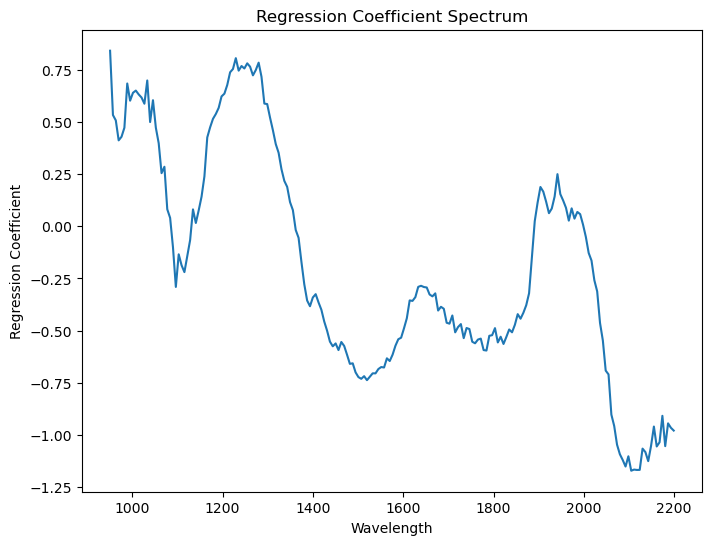

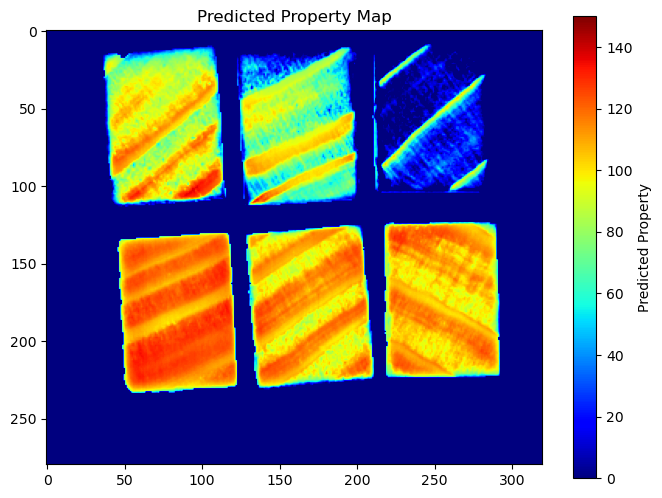

In [21]:
analyze_spectra(sample_extract, wave_extract, labels, [1,3,2,4,5,6],mc,3,1,0,150)

# <span style="color:RoyalBlue; ">12.6 Application of Convolutional Neural Networks (CNN) to HSI Data Analysis / 12.6 การประยุกต์ใช้โครงข่ายประสาทคอนโวลูชัน (CNN) กับการวิเคราะห์ข้อมูล HSI</span>
###### <span style="color: gray ">Code 12.20 Visualization of Spatial Distribution of Chemical Components via PCA / โค้ด 12.20 การแสดงภาพการกระจายตัวเชิงพื้นที่ขององค์ประกอบทางเคมีโดยใช้ PCA</span>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


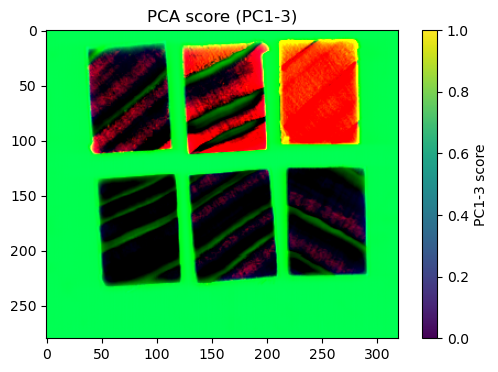

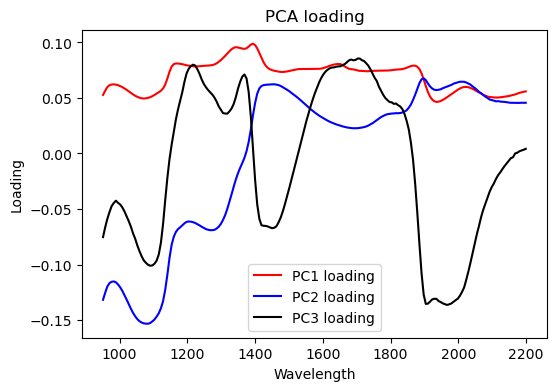

In [22]:
# Extract all spectra from regions with specified labels / ดึงสเปกตรัมทั้งหมดจากพื้นที่ที่มีป้ายกำกับ
wood_spectra = sample_extract[labels > 0]  # ① Extract spectra from regions with labels greater than 0 / ดึงสเปกตรัมจากพื้นที่ที่มีป้ายกำกับมากกว่า 0

# ② Perform PCA on the extracted spectra / ทำ PCA กับสเปกตรัมที่ดึงมา
pca = PCA(n_components=3)  # Initialize PCA with 3 components / เริ่มต้น PCA ด้วย 3 องค์ประกอบ
pca.fit(wood_spectra)  # Apply PCA to the extracted spectra / ใช้ PCA กับสเปกตรัมที่ดึงมา

# ③ Transform the entire dataset using the PCA model / แปลงชุดข้อมูลทั้งหมดโดยใช้โมเดล PCA
reshaped_sample = sample_extract.reshape(-1, sample_extract.shape[2])  # Reshape for PCA transformation / ปรับรูปร่างเพื่อใช้ PCA
pca_scores = pca.transform(reshaped_sample)  # Transform the data / แปลงข้อมูล
full_pca_scores = pca_scores.reshape(sample_extract.shape[0], sample_extract.shape[1], 3)  # Reshape to original dimensions / ปรับรูปร่างกลับเป็นขนาดเดิม

# Plot PCA scores of the first 3 components / แสดงคะแนน PCA ขององค์ประกอบ 3 อันดับแรก
plt.figure(figsize=(6, 4))
plt.imshow(full_pca_scores)
plt.colorbar(label='PC1-3 score')
plt.title('PCA score (PC1-3)')
plt.show()

# Display PCA loadings from PC1 to PC3 / แสดงโหลดดิ้งของ PCA จาก PC1 ถึง PC3
plt.figure(figsize=(6, 4))
plt.plot(wave_extract, pca.components_[0], label='PC1 loading', color='red')  # Plot PC1 loading / แสดงโหลดดิ้งของ PC1
plt.plot(wave_extract, pca.components_[1], label='PC2 loading', color='blue')  # Plot PC2 loading / แสดงโหลดดิ้งของ PC2
plt.plot(wave_extract, pca.components_[2], label='PC3 loading', color='black')  # Plot PC3 loading / แสดงโหลดดิ้งของ PC3
plt.xlabel('Wavelength')
plt.ylabel('Loading')
plt.title('PCA loading')
plt.legend()
plt.show()


###### <span style="color: gray ">Code 12.21: Extract pixels from each sample / โค้ด 12.21: แยกพิกเซลของแต่ละตัวอย่าง</span>


In [23]:
A6=full_pca_scores[120:240,37:127,:]
A5=full_pca_scores[120:240,125:215,:]
A4=full_pca_scores[120:240,213:303,:]
A3=full_pca_scores[0:120,30:120,:]
A2=full_pca_scores[0:120,120:210,:]
A1=full_pca_scores[0:120,205:295,:]

###### <span style="color: gray ">Code 12.22: Definition of CNN model and moisture content prediction using CNN / โค้ด 12.22: การกำหนดโมเดล CNN และการทำนายความชื้นด้วย CNN</span>


C:\Users\tetsu\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 118, 88, 32)         │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 59, 44, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 57, 42, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 28, 21, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 26, 19, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 31616)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │       2,023,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,079,873 (7.93 MB)

 Trainable params: 2,079,873 (7.93 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 7937.9634
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 6580.1694
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 4573.0259
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 2516.2185
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 2192.9272
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 1972.6334
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 832.5091
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 523.8019
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 678.8996
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 702.0485
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 453.0034
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 236.9206
Epoch 13/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 303.9810
Epoch 14/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 464.9354
Epoch 15/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 347.2529

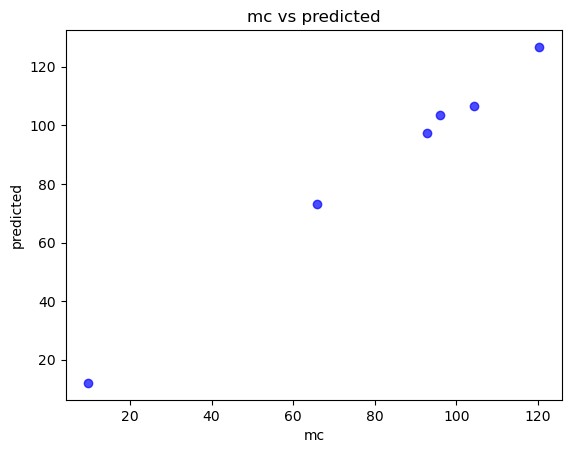

R2: 0.98
RMSE: 5.38


In [25]:
images = np.array([A1, A2, A3, A4, A5, A6])  # Store image data in a NumPy array / เก็บข้อมูลภาพไว้ในอาเรย์ NumPy
mc = np.array(mc)  # Store moisture content data in a NumPy array / เก็บข้อมูลความชื้นไว้ในอาเรย์ NumPy

# ① Define CNN model / กำหนดโมเดล CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(120, 90, 3)),  # Convolution layer / ชั้นคอนโวลูชัน
    MaxPooling2D((2, 2)),  # Pooling layer / ชั้นพูลลิง
    Conv2D(64, (3, 3), activation='relu'),  # Convolution layer / ชั้นคอนโวลูชัน
    MaxPooling2D((2, 2)),  # Pooling layer / ชั้นพูลลิง
    Conv2D(64, (3, 3), activation='relu'),  # Convolution layer / ชั้นคอนโวลูชัน
    Flatten(),  # Flatten layer / แปลงข้อมูลให้แบน
    Dense(64, activation='relu'),  # Fully connected layer / ชั้นเชื่อมต่อแบบเต็ม
    Dense(1)  # Output layer / ชั้นเอาต์พุต
])

# ② Compile the model / คอมไพล์โมเดล
model.compile(optimizer='adam', loss='mean_squared_error')  # Set optimizer and loss function / ตั้งค่าตัวปรับแต่งและฟังก์ชันสูญเสีย
model.summary()  # ③ Display model architecture / แสดงโครงสร้างของโมเดล

# Train the model with image and moisture content data / ฝึกโมเดลด้วยข้อมูลภาพและความชื้น
model.fit(images, mc, epochs=30)  #④ Train model / ฝึกโมเดล

# Predict moisture content / ทำนายค่าความชื้น
mc_pred = model.predict(images).flatten()  #⑤ Predict moisture content from image / ทำนายค่าความชื้นจากภาพ

# Plot predicted vs actual values / สร้างกราฟแสดงค่าทำนายเทียบกับค่าจริง
plt.scatter(mc, mc_pred, alpha=0.7, color='blue')
plt.xlabel('mc')
plt.ylabel('predicted')
plt.title('mc vs predicted')
plt.show()

# Calculate R2 and RMSE / คำนวณค่า R2 และ RMSE
r2 = r2_score(mc, mc_pred)  # Calculate R² / คำนวณค่าสัมประสิทธิ์การตัดสินใจ R²
mse = mean_squared_error(mc, mc_pred)  # Calculate MSE / คำนวณค่าเฉลี่ยกำลังสองของความคลาดเคลื่อน
rmse = np.sqrt(mse)
print(f'R2: {r2:.2f}')
print(f'RMSE: {rmse:.2f}')


## <span style="color: DeepPink; ">appendix Detecting Coins with OpenCV / ภาคผนวก การตรวจจับเหรียญด้วย OpenCV</span>
###### <span style="color: gray ">Code 12.23: Detecting coins from an image / โค้ด 12.23: ตรวจจับเหรียญจากภาพ</span>


Number of coins detected: 4
Contour 0: Area = 13018.00, Centroid = (90.85, 344.84)
Contour 1: Area = 9145.00, Centroid = (90.30, 174.22)
Contour 2: Area = 8212.50, Centroid = (245.94, 130.63)
Contour 3: Area = 8210.00, Centroid = (337.12, 61.76)


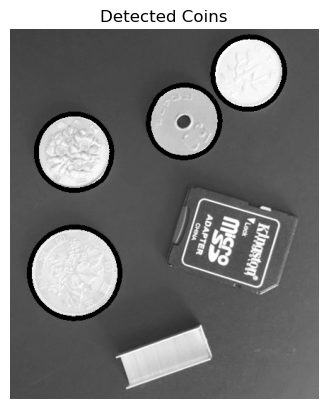

In [28]:
# Load image and convert to grayscale / โหลดภาพและแปลงเป็นภาพระดับสีเทา
img = cv2.imread("dataChapter12/coin.jpg", cv2.IMREAD_GRAYSCALE)

# Apply binary thresholding / ใช้การ Threshold แบบไบนารี
_, threshold = cv2.threshold(img, 160, 255, cv2.THRESH_BINARY)

# Extract contours / ดึงขอบของวัตถุในภาพ
contours, hierarchy = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Remove small contours / ลบขอบวัตถุที่มีขนาดเล็กเกินไป
contours2 = list(filter(lambda x: cv2.contourArea(x) >= 100, contours))

# Filter to keep only circular shapes / คัดกรองเฉพาะรูปร่างที่เป็นวงกลม
contours3 = []
for cnt in contours2:
    # Calculate contour perimeter / คำนวณความยาวเส้นรอบวงของขอบวัตถุ
    arclen = cv2.arcLength(cnt, True)
    # Approximate contour shape / ประมาณรูปร่างของขอบวัตถุ
    approx = cv2.approxPolyDP(cnt, 0.01 * arclen, True)
    # Keep shapes with >8 edges as circles / เก็บรูปร่างที่มีขอบมากกว่า 8 ด้านเป็นวงกลม
    if len(approx) > 8:
        contours3.append(cnt)

# Show number of detected coins / แสดงจำนวนเหรียญที่ตรวจพบ
print(f"Number of coins detected: {len(contours3)}")

for i, cnt in enumerate(contours3):
    # Calculate area of the contour / คำนวณพื้นที่ของขอบวัตถุ
    area = cv2.contourArea(cnt)
    # Calculate image moments / คำนวณโมเมนต์ของภาพ
    M = cv2.moments(cnt)
    # Compute centroid from moments / คำนวณจุดศูนย์กลางจากโมเมนต์
    cx = M["m10"] / M["m00"]
    cy = M["m01"] / M["m00"]
    print(f"Contour {i}: Area = {area:.2f}, Centroid = ({cx:.2f}, {cy:.2f})")

# Draw contours on the image / วาดขอบวัตถุบนภาพ
cv2.drawContours(img, contours3, -1, 2, 5)

# Display the result / แสดงผลลัพธ์
plt.imshow(img, cmap='gray')
plt.title("Detected Coins")
plt.axis("off")
plt.show()
